# Enviroment switch and dataset location cnofirmation

In [1]:
!pip install -q torch torchvision tqdm scikit-learn pandas numpy matplotlib seaborn Pillow kaggle

In [1]:
import torch, torchvision, sklearn, pandas, numpy, matplotlib, seaborn, PIL, kaggle

print("torch       :", torch.__version__)
print("torchvision :", torchvision.__version__)
print("sklearn     :", sklearn.__version__)
print("pandas      :", pandas.__version__)
print("numpy       :", numpy.__version__)
print("matplotlib  :", matplotlib.__version__)
print("seaborn     :", seaborn.__version__)
print("Pillow      :", PIL.__version__)
print("kaggle      :", getattr(kaggle, "__version__", "ok"))
print("CUDA avail  :", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU         :", torch.cuda.get_device_name(0))
    print("CUDA ver    :", torch.version.cuda)

torch       : 2.10.0+cu130
torchvision : 0.25.0+cu130
sklearn     : 1.8.0
pandas      : 2.2.1
numpy       : 1.26.4
matplotlib  : 3.10.8
seaborn     : 0.13.2
Pillow      : 10.2.0
kaggle      : 2.0.0
CUDA avail  : True
GPU         : NVIDIA GeForce RTX 5070 Ti
CUDA ver    : 13.0


In [4]:
ENV = "local"      # swtich to cvhange between colab or local
USE_DRIVE = False      # this is for colab if you want to use google drive

from pathlib import Path

from pathlib import Path

# BASE_DIR = Path.cwd()
# DOCS_DIR = BASE_DIR / "documents"
# LOCAL_BASE = DOCS_DIR / "i304x\DermaBoss\ICT304-AI-System-Design-Project\Isic2019"

# Assuming the dataset is in the same directory as this script
LOCAL_BASE = Path("./Isic2019")
 
DRIVE_BASE       = "/content/drive/MyDrive/archive"
COLAB_LOCAL_BASE = "/content/archive"


print(f"Environment   : {ENV.upper()}")
if ENV == "colab":
    print(f"Use Drive     : {USE_DRIVE}")
    print(f"Storage       : {DRIVE_BASE if USE_DRIVE else COLAB_LOCAL_BASE}")
else:
    print(f"Use Drive     : N/A  (local run)")
    print(f"Storage       : {LOCAL_BASE}")

Environment   : LOCAL
Use Drive     : N/A  (local run)
Storage       : Isic2019


In [5]:

import sys, os
import subprocess

# Validating the above set variables
assert ENV in ("local", "colab"), \
    f"ENV must be 'local' or 'colab', got: {ENV!r}"
assert isinstance(USE_DRIVE, bool), \
    f"USE_DRIVE must be True or False, got: {USE_DRIVE!r}"

if ENV == "local" and USE_DRIVE:
    print("ℹ  USE_DRIVE=True is ignored when ENV='local'.")

# Resolving the base path
if ENV == "colab":

    if USE_DRIVE:
        from google.colab import drive
        drive.mount("/content/drive", force_remount=False)
        BASE = DRIVE_BASE
        print("Google Drive mounted.")
        print(f"Dataset root: {BASE}")
    else:
        BASE = COLAB_LOCAL_BASE
        print("!Drive NOT used — data stored in /content.")
        print("!Re-download will happen every session.")
        print(f"Dataset root: {BASE}")

elif ENV == "local":
    BASE = LOCAL_BASE
    print(f"✓ Local mode.")
    print(f"  Dataset root → {BASE}")

# Resolving all downstream paths from base path
from pathlib import Path

BASE_PATH    = Path(BASE)
IMG_ROOT     = BASE_PATH / "ISIC_2019_Training_Input"
IMG_ROOT_256 = BASE_PATH / "ISIC_2019_Training_Input_256"
GT_CSV       = BASE_PATH / "ISIC_2019_Training_GroundTruth.csv"
META_CSV     = BASE_PATH / "ISIC_2019_Training_Metadata.csv"
CKPT_PATH    = BASE_PATH / "resnet18_isic2019_best.pt"
DONE_FLAG    = BASE_PATH / "_resize_complete.json"

BASE_PATH.mkdir(parents=True, exist_ok=True)

print(f"\n Resolved paths:")
print(f"  Base            : {BASE_PATH}")
print(f"  Images (raw)    : {IMG_ROOT}")
print(f"  Images (256 px) : {IMG_ROOT_256}")
print(f"  GT CSV          : {GT_CSV}")
print(f"  Checkpoint out  : {CKPT_PATH}")
print(f"  Resize flag     : {DONE_FLAG}")
print(f"\n")

✓ Local mode.
  Dataset root → Isic2019

 Resolved paths:
  Base            : Isic2019
  Images (raw)    : Isic2019\ISIC_2019_Training_Input
  Images (256 px) : Isic2019\ISIC_2019_Training_Input_256
  GT CSV          : Isic2019\ISIC_2019_Training_GroundTruth.csv
  Checkpoint out  : Isic2019\resnet18_isic2019_best.pt
  Resize flag     : Isic2019\_resize_complete.json




In [5]:
import os, random, warnings, time, json, threading, queue
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import tqdm


warnings.filterwarnings("ignore")
print(f"Python    : {sys.version.split()[0]}")
print(f"PyTorch   : {torch.__version__}")
print(f"CUDA avail: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU       : {torch.cuda.get_device_name(0)}")

Python    : 3.11.14
PyTorch   : 2.10.0+cu130
CUDA avail: True
GPU       : NVIDIA GeForce RTX 5070 Ti


In [19]:
# Cell 3 — Training config


CLASS_NAMES = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]   # ← 8 only
DROP_CLASS  = "UNK"

IMG_EXTS      = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
VAL_FRACTION  = 0.10
TEST_FRACTION = 0.10
RANDOM_SEED   = 42

BATCH_SIZE   = 64
NUM_EPOCHS   = 20
LR           = 2e-4
WEIGHT_DECAY = 1e-2

NUM_WORKERS      = 0
PREFETCH_THREADS = min(8, os.cpu_count())
PREFETCH_QUEUE   = PREFETCH_THREADS * 2

PIN_MEMORY = torch.cuda.is_available()
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sanity check — DROP_CLASS must not be in CLASS_NAMES
assert DROP_CLASS not in CLASS_NAMES, \
    f"'{DROP_CLASS}' must not appear in CLASS_NAMES — remove it!"

print(f"Classes          : {CLASS_NAMES}  ({len(CLASS_NAMES)} classes)")
print(f"Dropped class    : {DROP_CLASS}  (filtered from CSV in C1, not a model output)")
print(f"Split            : 80% train / 10% val / 10% test")
print(f"Device           : {DEVICE}")
print(f"Batch size       : {BATCH_SIZE}")
print(f"Epochs           : {NUM_EPOCHS}")
print(f"Prefetch threads : {PREFETCH_THREADS}  queue: {PREFETCH_QUEUE}")
print(f"Pin memory       : {PIN_MEMORY}")

Classes          : ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']  (8 classes)
Dropped class    : UNK  (filtered from CSV in C1, not a model output)
Split            : 80% train / 10% val / 10% test
Device           : cuda
Batch size       : 64
Epochs           : 20
Prefetch threads : 8  queue: 16
Pin memory       : True


In [7]:
# Dataset checker + downloader
# Download sources (public, no login required):
#   Images ZIP : https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip
#   GT CSV     : https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv
#   Meta CSV   : https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Metadata.csv
# The ZIP is ~9 GB
# On Colab without Drive it re-downloads every session.

import urllib.request, zipfile, shutil

URLS = {
    "gt_csv"  : "https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv",
    "meta_csv": "https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Metadata.csv",
    "images"  : "https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip",
}

ZIP_PATH = BASE_PATH / "ISIC_2019_Training_Input.zip"


def _progress_hook(desc: str):
    from tqdm.notebook import tqdm as _tqdm
    pbar = [None]
    def hook(block_num, block_size, total_size):
        if pbar[0] is None:
            pbar[0] = _tqdm(total=total_size, unit="B", unit_scale=True,
                            unit_divisor=1024, desc=desc)
        pbar[0].update(min(block_size, total_size - pbar[0].n))
        if block_num * block_size >= total_size:
            pbar[0].close()
    return hook


def download_file(url: str, dest: Path, desc: str):
    dest.parent.mkdir(parents=True, exist_ok=True)
    print(f"  Downloading {desc} …")
    urllib.request.urlretrieve(url, dest, reporthook=_progress_hook(desc))
    print(f"  Saved → {dest}  ({dest.stat().st_size / 1024**2:.1f} MB)")


# Ground-truth CSV
if GT_CSV.exists():
    print(f"✓ GT CSV found      : {GT_CSV}")
else:
    print(f"✗ GT CSV missing — downloading …")
    download_file(URLS["gt_csv"], GT_CSV, "GroundTruth CSV")

# Metadata CSV
if META_CSV.exists():
    print(f"✓ Meta CSV found    : {META_CSV}")
else:
    print(f"✗ Meta CSV missing — downloading …")
    download_file(URLS["meta_csv"], META_CSV, "Metadata CSV")

# Images
if IMG_ROOT.exists() and any(IMG_ROOT.rglob("*.jpg")):
    img_count = sum(1 for _ in IMG_ROOT.rglob("*.jpg"))
    print(f"✓ Images found      : {IMG_ROOT}  ({img_count:,} JPEGs)")
else:
    print(f"✗ Image folder missing or empty.")

    if not ZIP_PATH.exists():
        print(f"\n⚠  This download is ~9 GB and may take 10–30 min.")
        print(f"   On local, consider manual download if on a slow connection.")
        download_file(URLS["images"], ZIP_PATH, "ISIC 2019 Images ZIP")
    else:
        print(f"  ZIP already present: {ZIP_PATH}")

    print(f"\nExtracting ZIP → {BASE_PATH} …")
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        for member in tqdm(zf.namelist(), desc="Extracting", unit="file"):
            zf.extract(member, BASE_PATH)
    print("Extraction complete.")

    answer = input("Delete ZIP to save disk space? [y/N]: ").strip().lower()
    if answer == "y":
        ZIP_PATH.unlink()
        print("ZIP deleted.")
    else:
        print("ZIP kept.")

    img_count = sum(1 for _ in IMG_ROOT.rglob("*.jpg"))
    print(f"✓ Images ready: {img_count:,} files in {IMG_ROOT}")

print("\n✓ Dataset acquisition complete. Proceed to Section B.")

✓ GT CSV found      : C:\Users\Mohammad\Downloads\archieve\ISIC_2019_Training_GroundTruth.csv
✓ Meta CSV found    : C:\Users\Mohammad\Downloads\archieve\ISIC_2019_Training_Metadata.csv
✓ Images found      : C:\Users\Mohammad\Downloads\archieve\ISIC_2019_Training_Input  (25,331 JPEGs)

✓ Dataset acquisition complete. Proceed to Section B.


## Preprocessing

In [8]:
# Cell B1 — Check if pre-resize has already been done
if DONE_FLAG.exists():
    meta = json.loads(DONE_FLAG.read_text())
    print(f"Pre-resize already completed.")
    print(f"Date    : {meta['date']}")
    print(f"Total   : {meta['total']:,} images")
    print(f"Resized : {meta['resized']:,}")
    print(f"Skipped : {meta['skipped']:,}  (already existed)")
    print(f"Errors  : {meta['errors']}")
    print(f"\nSkip to Section C (training).")
else:
    img_count = sum(1 for _ in IMG_ROOT.rglob("*.jpg"))
    print(f"Pre-resize not done yet.")
    print(f"Source images found : {img_count:,}")
    print(f"Run Cell B2 to start (~10–20 min, one-time only).")

Pre-resize not done yet.
Source images found : 25,331
Run Cell B2 to start (~10–20 min, one-time only).


In [9]:
# Cell B2 — Resize all images to 256 px max side (idempotent / resumable)
import datetime

if DONE_FLAG.exists():
    print("✓ Already done — skipping. Jump to Section C.")
else:
    all_imgs = [p for p in IMG_ROOT.rglob("*") if p.suffix.lower() in IMG_EXTS]
    total = len(all_imgs)
    skipped, resized, errors = 0, 0, []

    print(f"Resizing {total:,} images → {IMG_ROOT_256}")
    print("Safe to interrupt and re-run (already-done files are skipped).\n")

    for src in tqdm(all_imgs, unit="img", desc="Resizing"):
        rel  = src.relative_to(IMG_ROOT)
        dest = IMG_ROOT_256 / rel.with_suffix(".jpg")
        dest.parent.mkdir(parents=True, exist_ok=True)

        if dest.exists():
            skipped += 1
            continue
        try:
            img = Image.open(src).convert("RGB")
            img.thumbnail((256, 256), Image.LANCZOS)
            img.save(dest, "JPEG", quality=95)
            resized += 1
        except Exception as e:
            errors.append((str(src), str(e)))

    DONE_FLAG.write_text(json.dumps({
        "date"   : datetime.datetime.now().isoformat(timespec="seconds"),
        "total"  : resized + skipped,
        "resized": resized,
        "skipped": skipped,
        "errors" : len(errors),
    }, indent=2))

    print(f"\n✓ Done.")
    print(f"  Resized : {resized:,}")
    print(f"  Skipped : {skipped:,}")
    print(f"  Errors  : {len(errors)}")
    if errors:
        for p, e in errors[:5]:
            print(f"    {p}  →  {e}")
    print(f"\n→ Proceed to Section C.")

Resizing 25,331 images → C:\Users\Mohammad\Downloads\archieve\ISIC_2019_Training_Input_256
Safe to interrupt and re-run (already-done files are skipped).



Resizing:   0%|          | 0/25331 [00:00<?, ?img/s]


✓ Done.
  Resized : 25,331
  Skipped : 0
  Errors  : 0

→ Proceed to Section C.


In [10]:
# Cell B3 — Verify resized dataset (optional but recommended after B2)
import random

dest_imgs = list(IMG_ROOT_256.rglob("*.jpg"))
print(f"Resized images found: {len(dest_imgs):,}")

sample = random.sample(dest_imgs, min(5, len(dest_imgs)))
print("\nRandom sample:")
for p in sample:
    img = Image.open(p)
    print(f"  {p.name:<40}  size={img.size}  mode={img.mode}")

print("\n Sanity check passed. Proceed to Section C.")

Resized images found: 25,331

Random sample:
  ISIC_0059544.jpg                          size=(256, 256)  mode=RGB
  ISIC_0069459.jpg                          size=(256, 256)  mode=RGB
  ISIC_0061418.jpg                          size=(256, 256)  mode=RGB
  ISIC_0067109.jpg                          size=(256, 256)  mode=RGB
  ISIC_0026443.jpg                          size=(256, 192)  mode=RGB

✓ Sanity check passed. Proceed to Section C.


## Run before Training and Evaluation

In [11]:
# Cell C1 — Load CSV, drop UNK, convert one-hot → integer labels
ALL_CSV_CLASSES = CLASS_NAMES + [DROP_CLASS]

df = pd.read_csv(GT_CSV)
print(f"CSV rows (raw)   : {len(df):,}   cols: {df.shape[1]}")

row_sums = df[ALL_CSV_CLASSES].sum(axis=1)
assert (row_sums == 1).all(), "Some rows are not strictly one-hot!"

unk_mask  = df[DROP_CLASS] == 1
unk_count = unk_mask.sum()
df = df[~unk_mask].reset_index(drop=True)
print(f"Dropped '{DROP_CLASS}' rows : {unk_count:,}")
print(f"CSV rows (clean) : {len(df):,}")

df["label"] = df[CLASS_NAMES].values.argmax(axis=1)

assert df["label"].between(0, len(CLASS_NAMES) - 1).all(), \
    "Label out of expected range!"

print(f"\nClass distribution (UNK removed):")
dist    = df["label"].map(lambda i: CLASS_NAMES[i]).value_counts()
max_cnt = dist.max()
for cls, cnt in dist.items():
    bar = "█" * int(cnt / max_cnt * 40)
    print(f"  {cls:>5s}: {cnt:>6,}  {bar}")

print(f"\nTotal usable samples: {len(df):,}")

CSV rows (raw)   : 25,331   cols: 10
Dropped 'UNK' rows : 0
CSV rows (clean) : 25,331

Class distribution (UNK removed):
     NV: 12,875  ████████████████████████████████████████
    MEL:  4,522  ██████████████
    BCC:  3,323  ██████████
    BKL:  2,624  ████████
     AK:    867  ██
    SCC:    628  █
   VASC:    253  
     DF:    239  

Total usable samples: 25,331


In [12]:
# Cell C2 — Recursive image index from pre-resized folder
print(f"Scanning: {IMG_ROOT_256}")

stem_to_path: dict[str, Path] = {}
for p in IMG_ROOT_256.rglob("*"):
    if p.suffix.lower() in IMG_EXTS:
        stem_to_path[p.stem] = p

print(f"Found {len(stem_to_path):,} image files")

df["filepath"] = df["image"].map(stem_to_path)
missing = df["filepath"].isna().sum()
print(f"Unmatched rows : {missing}  (should be 0)")
if missing:
    print("  Sample missing IDs:", df[df["filepath"].isna()]["image"].tolist()[:10])

df = df.dropna(subset=["filepath"]).reset_index(drop=True)
print(f"Final dataset  : {len(df):,} rows")

Scanning: C:\Users\Mohammad\Downloads\archieve\ISIC_2019_Training_Input_256
Found 25,331 image files
Unmatched rows : 0  (should be 0)
Final dataset  : 25,331 rows


In [20]:
# Cell C3 — Stratified 80/10/10 split
#
# Strategy: split once to carve out test (10%), then split the
# remainder 88.9/11.1 to get val = 10% of total.
# Stratify both splits to preserve class proportions throughout.

# Step 1: hold out 10% as test set
train_val_df, test_df = train_test_split(
    df,
    test_size=TEST_FRACTION,
    random_state=RANDOM_SEED,
    stratify=df["label"],
)

# Step 2: from the remaining 90%, hold out 1/9 ≈ 11.1% as val
# → val ends up as 10% of the original total
val_relative = VAL_FRACTION / (1.0 - TEST_FRACTION)   # 0.10 / 0.90 ≈ 0.1111

train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_relative,
    random_state=RANDOM_SEED,
    stratify=train_val_df["label"],
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

total = len(df)
print(f"Total samples : {total:,}")
print(f"  Train       : {len(train_df):,}  ({len(train_df)/total*100:.1f}%)")
print(f"  Val         : {len(val_df):,}  ({len(val_df)/total*100:.1f}%)")
print(f"  Test        : {len(test_df):,}  ({len(test_df)/total*100:.1f}%)")

# Verify class proportions are preserved in all three splits
print(f"\nClass balance check (% of each split):")
print(f"  {'Class':<8}", end="")
for split_name in ["Train", "Val", "Test"]:
    print(f"  {split_name:>8}", end="")
print()

for i, cls in enumerate(CLASS_NAMES):
    print(f"  {cls:<8}", end="")
    for split_df in [train_df, val_df, test_df]:
        pct = (split_df["label"] == i).sum() / len(split_df) * 100
        print(f"  {pct:>7.2f}%", end="")
    print()

Total samples : 25,331
  Train       : 20,264  (80.0%)
  Val         : 2,533  (10.0%)
  Test        : 2,534  (10.0%)

Class balance check (% of each split):
  Class        Train       Val      Test
  MEL         17.85%    17.84%    17.84%
  NV          50.82%    50.85%    50.83%
  BCC         13.12%    13.11%    13.10%
  AK           3.42%     3.43%     3.43%
  BKL         10.36%    10.34%    10.38%
  DF           0.94%     0.95%     0.95%
  VASC         1.00%     0.99%     0.99%
  SCC          2.48%     2.49%     2.49%


In [14]:
# Cell C4 — Dataset + DataLoaders + ThreadedPrefetcher

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Val and test use the same deterministic transform — no augmentation
eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


class SkinLesionDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transform=None):
        self.df        = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row   = self.df.iloc[idx]
        image = Image.open(row["filepath"]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, int(row["label"])


train_loader = DataLoader(
    SkinLesionDataset(train_df, train_transform),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
)
val_loader = DataLoader(
    SkinLesionDataset(val_df, eval_transform),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
)
test_loader = DataLoader(
    SkinLesionDataset(test_df, eval_transform),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
)

print(f"Train batches : {len(train_loader):,}")
print(f"Val   batches : {len(val_loader):,}")
print(f"Test  batches : {len(test_loader):,}")


class ThreadedPrefetcher:
    """Prefetches DataLoader batches on background threads — no pickling."""

    def __init__(self, dataloader, num_threads: int = 4, queue_size: int = 8):
        self.dataloader  = dataloader
        self.num_threads = num_threads
        self.queue_size  = queue_size

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):
        batch_q     = queue.Queue(maxsize=self.queue_size)
        _DONE       = object()
        loader_iter = iter(self.dataloader)
        iter_lock   = threading.Lock()
        n_done      = [0]
        done_lock   = threading.Lock()

        def worker():
            while True:
                with iter_lock:
                    try:
                        batch = next(loader_iter)
                    except StopIteration:
                        break
                if PIN_MEMORY and DEVICE.type == "cuda":
                    batch = tuple(
                        t.pin_memory() if isinstance(t, torch.Tensor) else t
                        for t in batch
                    )
                batch_q.put(batch)
            with done_lock:
                n_done[0] += 1
                if n_done[0] == self.num_threads:
                    batch_q.put(_DONE)

        threads = [threading.Thread(target=worker, daemon=True)
                   for _ in range(self.num_threads)]
        for t in threads:
            t.start()

        while True:
            item = batch_q.get()
            if item is _DONE:
                break
            yield item

        for t in threads:
            t.join()


train_prefetcher = ThreadedPrefetcher(
    train_loader,
    num_threads=PREFETCH_THREADS,
    queue_size=PREFETCH_QUEUE,
)
val_prefetcher = ThreadedPrefetcher(
    val_loader,
    num_threads=max(2, PREFETCH_THREADS // 2),
    queue_size=max(4, PREFETCH_QUEUE  // 2),
)
test_prefetcher = ThreadedPrefetcher(
    test_loader,
    num_threads=max(2, PREFETCH_THREADS // 2),
    queue_size=max(4, PREFETCH_QUEUE  // 2),
)

print(f"\nThreadedPrefetcher ready.")
print(f"  Train : {len(train_prefetcher)} batches")
print(f"  Val   : {len(val_prefetcher)} batches")
print(f"  Test  : {len(test_prefetcher)} batches")

Train batches : 317
Val   batches : 40
Test  batches : 40

ThreadedPrefetcher ready.
  Train : 317 batches
  Val   : 40 batches
  Test  : 40 batches


In [21]:
# Cell C5 — ResNet-18 with 8-class FC head
NUM_CLASSES = len(CLASS_NAMES)   # 8

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model    = model.to(DEVICE)

total_p     = sum(p.numel() for p in model.parameters())
trainable_p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Output classes   : {NUM_CLASSES}  {CLASS_NAMES}")
print(f"Total params     : {total_p:,}")
print(f"Trainable params : {trainable_p:,}")
print(f"Model on device  : {next(model.parameters()).device}")

Output classes   : 8  ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
Total params     : 11,180,616
Trainable params : 11,180,616
Model on device  : cuda:0


In [16]:
# Cell C6 — GPU pipeline proof
t0 = time.perf_counter()
sample_imgs, sample_labels = next(iter(train_prefetcher))
load_ms = (time.perf_counter() - t0) * 1000

sample_imgs   = sample_imgs.to(DEVICE, non_blocking=True)
sample_labels = sample_labels.to(DEVICE, non_blocking=True)

with torch.no_grad():
    t1  = time.perf_counter()
    out = model(sample_imgs)
    if DEVICE.type == "cuda":
        torch.cuda.synchronize()
    fwd_ms = (time.perf_counter() - t1) * 1000

tag = "from queue — fast ✓" if load_ms < 200 else "cold start — next will be faster"
print(f"Batch load time       : {load_ms:.1f} ms  ({tag})")
print(f"GPU forward pass      : {fwd_ms:.1f} ms")
print(f"Model device          : {next(model.parameters()).device}")
print(f"Batch (images) device : {sample_imgs.device}")
print(f"Batch (labels) device : {sample_labels.device}")
print(f"Output device         : {out.device}")
print(f"Output shape          : {out.shape}")    # expect (BATCH_SIZE, 8)

assert out.shape[1] == NUM_CLASSES, \
    f"Output has {out.shape[1]} classes, expected {NUM_CLASSES}!"

if DEVICE.type == "cuda":
    alloc = torch.cuda.memory_allocated() / 1024**2
    res   = torch.cuda.memory_reserved()  / 1024**2
    print(f"\nGPU VRAM — allocated : {alloc:.1f} MB  reserved : {res:.1f} MB")

Batch load time       : 718.9 ms  (cold start — next will be faster)
GPU forward pass      : 344.4 ms
Model device          : cuda:0
Batch (images) device : cuda:0
Batch (labels) device : cuda:0
Output device         : cuda:0
Output shape          : torch.Size([64, 9])

GPU VRAM — allocated : 88.6 MB  reserved : 496.0 MB


In [22]:
# Cell C7 — Weighted CrossEntropyLoss
NUM_CLASSES = len(CLASS_NAMES)   # 8  (UNK already dropped in C1)

raw_counts   = train_df["label"].value_counts()
label_counts = (
    raw_counts
    .reindex(range(NUM_CLASSES), fill_value=0)
    .sort_index()
    .values
    .astype(float)
)

# Hard check: if UNK somehow survived C1 it would push a label index of 8
# which is out of range for 8 classes — catch it immediately.
assert train_df["label"].max() <= NUM_CLASSES - 1, \
    f"Label index {train_df['label'].max()} out of range for {NUM_CLASSES} classes. " \
    f"Did C1 (UNK drop) run correctly?"

assert len(label_counts) == NUM_CLASSES, \
    f"Expected {NUM_CLASSES} weight slots, got {len(label_counts)}. " \
    f"Check that CLASS_NAMES does not include '{DROP_CLASS}'."

label_counts_safe = label_counts.clip(min=1.0)
weights       = label_counts_safe.sum() / (NUM_CLASSES * label_counts_safe)
class_weights = torch.tensor(weights, dtype=torch.float32).to(DEVICE)

assert not torch.isnan(class_weights).any(), "NaN in class weights!"

print(f"{'Class':<8} {'Samples':>10} {'Weight':>10}")
print("─" * 32)
for i in range(NUM_CLASSES):
    print(f"{CLASS_NAMES[i]:<8} {int(label_counts[i]):>10,} "
          f"{class_weights[i].item():>10.4f}")

criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"\n✓ CrossEntropyLoss ready  ({NUM_CLASSES} classes, no UNK).")

Class       Samples     Weight
────────────────────────────────
MEL           3,618     0.7001
NV           10,299     0.2459
BCC           2,659     0.9526
AK              693     3.6551
BKL           2,099     1.2068
DF              191    13.2618
VASC            203    12.4778
SCC             502     5.0458

✓ CrossEntropyLoss ready  (8 classes, no UNK).


In [23]:
# Cell C8 — Optimizer & scheduler
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=3,
)

print(f"AdamW              lr={LR}  wd={WEIGHT_DECAY}")
print(f"ReduceLROnPlateau  mode=max  factor=0.5  patience=3")
print(f"Starting LR        : {optimizer.param_groups[0]['lr']:.2e}")

AdamW              lr=0.0002  wd=0.01
ReduceLROnPlateau  mode=max  factor=0.5  patience=3
Starting LR        : 2.00e-04


## Training

In [24]:
# Cell D1 — Training loop
best_val_acc = 0.0
history      = []

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch:>3d}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    # ── Train ──────────────────────────────────────────────────────────────────
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    train_bar = tqdm(
        train_prefetcher,
        total=len(train_prefetcher),
        desc="  Train",
        leave=False,
        unit="batch",
    )

    for imgs, labels in train_bar:
        imgs   = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()
        logits = model(imgs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        bs             = imgs.size(0)
        train_loss    += loss.item() * bs
        train_correct += (logits.argmax(1) == labels).sum().item()
        train_total   += bs
        train_bar.set_postfix(loss=f"{loss.item():.4f}")

    t_loss = train_loss / train_total
    t_acc  = train_correct / train_total

    # ── Validate ───────────────────────────────────────────────────────────────
    model.eval()
    val_loss_sum, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        val_bar = tqdm(
            val_prefetcher,
            total=len(val_prefetcher),
            desc="  Val  ",
            leave=False,
            unit="batch",
        )
        for imgs, labels in val_bar:
            imgs   = imgs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            logits = model(imgs)
            loss   = criterion(logits, labels)
            bs           = imgs.size(0)
            val_loss_sum += loss.item() * bs
            val_correct  += (logits.argmax(1) == labels).sum().item()
            val_total    += bs

    v_loss = val_loss_sum / val_total
    v_acc  = val_correct  / val_total

    scheduler.step(v_acc)
    current_lr = optimizer.param_groups[0]["lr"]

    history.append(dict(
        epoch=epoch,
        train_loss=t_loss, train_acc=t_acc,
        val_loss=v_loss,   val_acc=v_acc,
        lr=current_lr,
    ))

    print(f"  Train  loss: {t_loss:.4f}  acc: {t_acc:.4f}")
    print(f"  Val    loss: {v_loss:.4f}  acc: {v_acc:.4f}")
    print(f"  LR         : {current_lr:.2e}")

    if v_acc > best_val_acc:
        best_val_acc = v_acc
        torch.save(
            {
                "epoch"       : epoch,
                "model_state" : model.state_dict(),
                "optim_state" : optimizer.state_dict(),
                "val_acc"     : v_acc,
                "class_names" : CLASS_NAMES,
                "drop_class"  : DROP_CLASS,
            },
            CKPT_PATH,
        )
        print(f"  ✓ New best val acc {v_acc:.4f} — checkpoint saved.")

print(f"\nTraining complete.  Best val acc: {best_val_acc:.4f}")
print(f"Checkpoint: {CKPT_PATH}")


Epoch   1/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 1.4237  acc: 0.5184
  Val    loss: 1.1539  acc: 0.5882
  LR         : 2.00e-04
  ✓ New best val acc 0.5882 — checkpoint saved.

Epoch   2/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 1.1406  acc: 0.5888
  Val    loss: 1.0656  acc: 0.5855
  LR         : 2.00e-04

Epoch   3/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 1.0227  acc: 0.6126
  Val    loss: 0.9436  acc: 0.6589
  LR         : 2.00e-04
  ✓ New best val acc 0.6589 — checkpoint saved.

Epoch   4/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.9534  acc: 0.6320
  Val    loss: 0.9212  acc: 0.6494
  LR         : 2.00e-04

Epoch   5/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.8764  acc: 0.6484
  Val    loss: 1.0273  acc: 0.5973
  LR         : 2.00e-04

Epoch   6/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.8528  acc: 0.6538
  Val    loss: 0.9137  acc: 0.6932
  LR         : 2.00e-04
  ✓ New best val acc 0.6932 — checkpoint saved.

Epoch   7/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.7912  acc: 0.6730
  Val    loss: 0.8591  acc: 0.6747
  LR         : 2.00e-04

Epoch   8/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.7516  acc: 0.6801
  Val    loss: 0.8677  acc: 0.5910
  LR         : 2.00e-04

Epoch   9/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.7074  acc: 0.6938
  Val    loss: 0.8076  acc: 0.6510
  LR         : 2.00e-04

Epoch  10/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.6686  acc: 0.7064
  Val    loss: 0.8449  acc: 0.6739
  LR         : 1.00e-04

Epoch  11/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.5412  acc: 0.7494
  Val    loss: 0.6995  acc: 0.7011
  LR         : 1.00e-04
  ✓ New best val acc 0.7011 — checkpoint saved.

Epoch  12/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.4666  acc: 0.7721
  Val    loss: 0.6364  acc: 0.7367
  LR         : 1.00e-04
  ✓ New best val acc 0.7367 — checkpoint saved.

Epoch  13/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.4125  acc: 0.7886
  Val    loss: 0.6857  acc: 0.7371
  LR         : 1.00e-04
  ✓ New best val acc 0.7371 — checkpoint saved.

Epoch  14/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.4034  acc: 0.7903
  Val    loss: 0.7061  acc: 0.7410
  LR         : 1.00e-04
  ✓ New best val acc 0.7410 — checkpoint saved.

Epoch  15/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.4003  acc: 0.8028
  Val    loss: 0.6556  acc: 0.7430
  LR         : 1.00e-04
  ✓ New best val acc 0.7430 — checkpoint saved.

Epoch  16/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.3777  acc: 0.8023
  Val    loss: 0.7034  acc: 0.7422
  LR         : 1.00e-04

Epoch  17/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.3501  acc: 0.8123
  Val    loss: 0.6548  acc: 0.7734
  LR         : 1.00e-04
  ✓ New best val acc 0.7734 — checkpoint saved.

Epoch  18/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.3118  acc: 0.8291
  Val    loss: 0.7457  acc: 0.7651
  LR         : 1.00e-04

Epoch  19/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.3066  acc: 0.8329
  Val    loss: 0.7509  acc: 0.7544
  LR         : 1.00e-04

Epoch  20/20


  Train:   0%|          | 0/317 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/40 [00:00<?, ?batch/s]

  Train  loss: 0.3016  acc: 0.8362
  Val    loss: 0.6827  acc: 0.7580
  LR         : 1.00e-04

Training complete.  Best val acc: 0.7734
Checkpoint: C:\Users\Mohammad\Downloads\archieve\resnet18_isic2019_best.pt


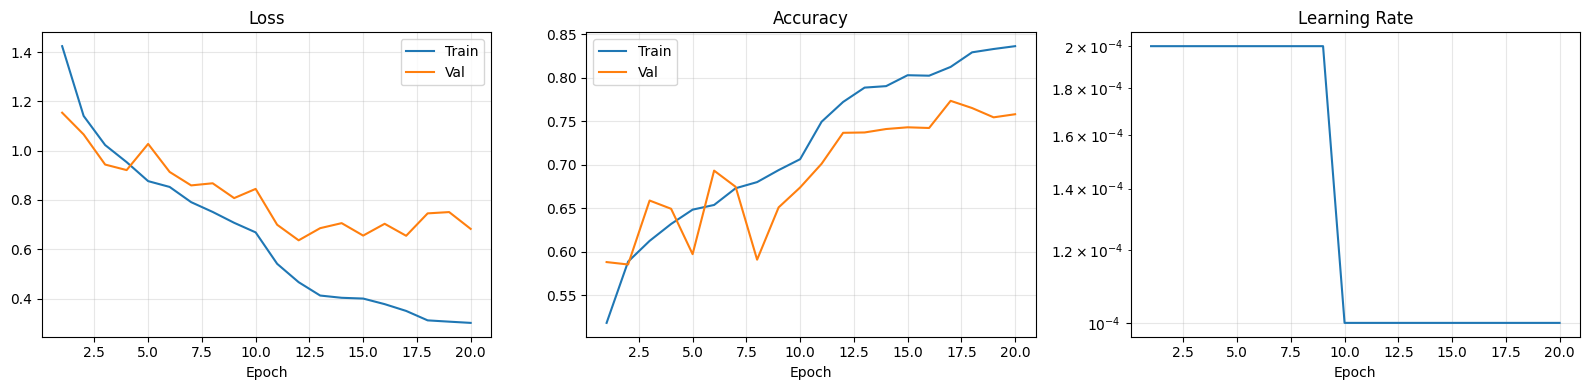

Saved → C:\Users\Mohammad\Downloads\archieve\training_curves.png


In [25]:
# Cell D2 — Training curves: loss, accuracy, learning rate
import matplotlib.pyplot as plt

hist_df = pd.DataFrame(history)
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].plot(hist_df["epoch"], hist_df["train_loss"], label="Train")
axes[0].plot(hist_df["epoch"], hist_df["val_loss"],   label="Val")
axes[0].set_title("Loss"); axes[0].set_xlabel("Epoch")
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(hist_df["epoch"], hist_df["train_acc"], label="Train")
axes[1].plot(hist_df["epoch"], hist_df["val_acc"],   label="Val")
axes[1].set_title("Accuracy"); axes[1].set_xlabel("Epoch")
axes[1].legend(); axes[1].grid(True, alpha=0.3)

axes[2].plot(hist_df["epoch"], hist_df["lr"])
axes[2].set_title("Learning Rate"); axes[2].set_xlabel("Epoch")
axes[2].set_yscale("log"); axes[2].grid(True, alpha=0.3)

plt.tight_layout()
out_fig = CKPT_PATH.parent / "training_curves.png"
plt.savefig(out_fig, dpi=120)
plt.show()
print(f"Saved → {out_fig}")

## Eval

In [26]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.preprocessing import label_binarize

# Load checkpoint/model
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
print(f"Loaded checkpoint")
print(f"  Epoch     : {ckpt['epoch']}")
print(f"  Val acc   : {ckpt['val_acc']:.4f}  (validation — used for model selection)")
print(f"  Classes   : {ckpt['class_names']}")

# Inference on test set
model.eval()
all_labels = []
all_preds  = []
all_probs  = []

with torch.no_grad():
    for imgs, labels in tqdm(test_prefetcher, total=len(test_prefetcher),
                              desc="Test inference", unit="batch"):
        imgs   = imgs.to(DEVICE, non_blocking=True)
        logits = model(imgs)
        probs  = torch.softmax(logits, dim=1).cpu()
        preds  = logits.argmax(1).cpu()

        all_probs.append(probs.numpy())
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.vstack(all_probs)

labels_bin = label_binarize(all_labels, classes=list(range(NUM_CLASSES)))

test_acc = (all_preds == all_labels).mean()
print(f"\n✓ Test inference complete on {len(all_labels):,} held-out samples.")
print(f"  Test accuracy  : {test_acc:.4f}  ← honest final number")
print(f"  Val accuracy   : {ckpt['val_acc']:.4f}  ← used only for checkpoint selection")

Loaded checkpoint
  Epoch     : 17
  Val acc   : 0.7734  (validation — used for model selection)
  Classes   : ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']


Test inference:   0%|          | 0/40 [00:00<?, ?batch/s]


✓ Test inference complete on 2,534 held-out samples.
  Test accuracy  : 0.7628  ← honest final number
  Val accuracy   : 0.7734  ← used only for checkpoint selection


Classification Report:
              precision    recall  f1-score   support

         MEL     0.6841    0.6372    0.6598       452
          NV     0.8954    0.8245    0.8585      1288
         BCC     0.8262    0.7590    0.7912       332
          AK     0.4741    0.7356    0.5766        87
         BKL     0.5728    0.6882    0.6252       263
          DF     0.4872    0.7917    0.6032        24
        VASC     0.8462    0.8800    0.8627        25
         SCC     0.4245    0.7143    0.5325        63

    accuracy                         0.7628      2534
   macro avg     0.6513    0.7538    0.6887      2534
weighted avg     0.7847    0.7628    0.7699      2534



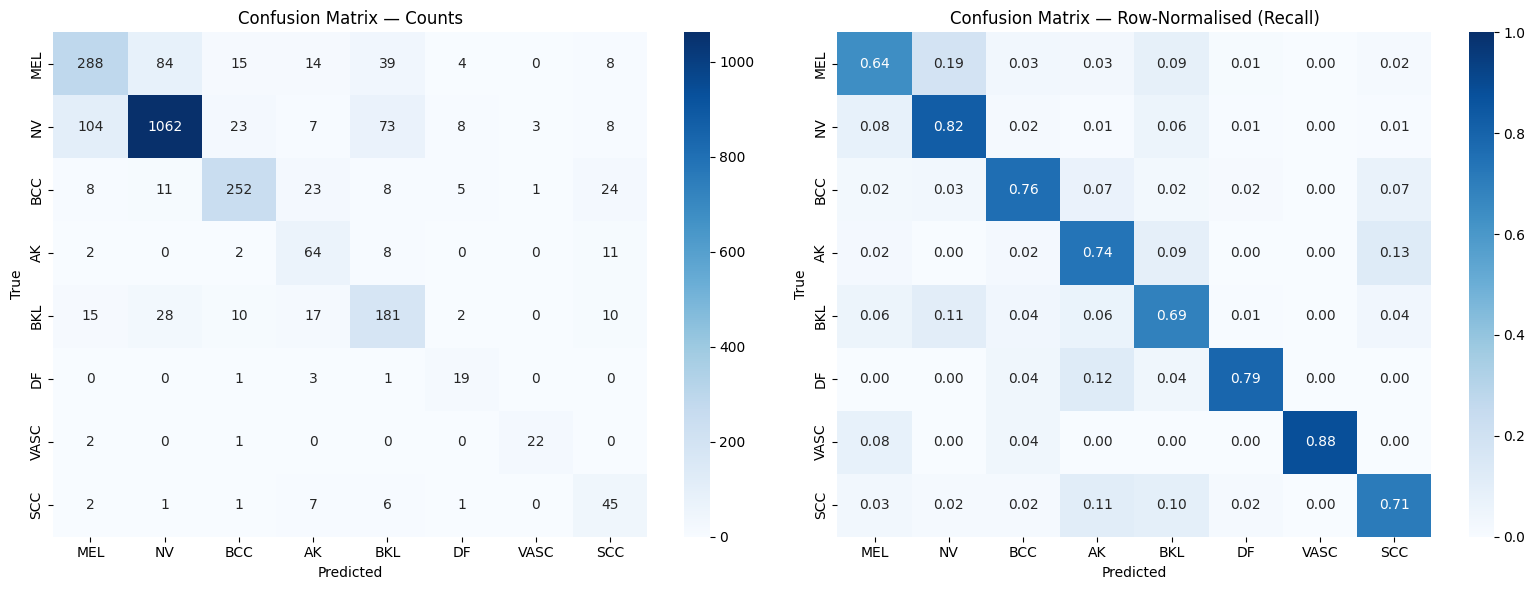

Saved → C:\Users\Mohammad\Downloads\archieve\confusion_matrix.png


In [27]:

print("Classification Report:")
print(classification_report(all_labels, all_preds,
                             target_names=CLASS_NAMES, digits=4))

cm = confusion_matrix(all_labels, all_preds)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cmap="Blues", ax=axes[0])
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
axes[0].set_title("Confusion Matrix — Counts")


cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cmap="Blues", vmin=0, vmax=1, ax=axes[1])
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
axes[1].set_title("Confusion Matrix — Row-Normalised (Recall)")

plt.tight_layout()
out_cm = CKPT_PATH.parent / "confusion_matrix.png"
plt.savefig(out_cm, dpi=120)
plt.show()
print(f"Saved → {out_cm}")

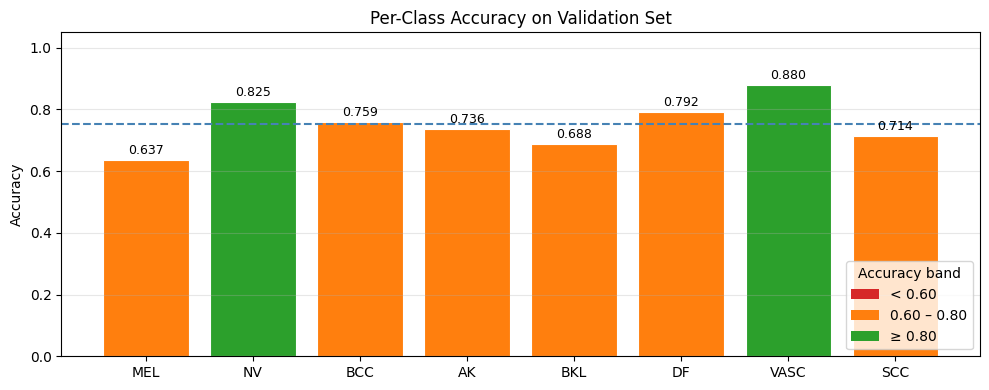

Saved → C:\Users\Mohammad\Downloads\archieve\per_class_accuracy.png


In [28]:

per_class_acc = []
for i in range(NUM_CLASSES):
    mask = all_labels == i
    if mask.sum() == 0:
        per_class_acc.append(0.0)
    else:
        per_class_acc.append((all_preds[mask] == i).mean())

fig, ax = plt.subplots(figsize=(10, 4))

colors = ["#d62728" if a < 0.6 else "#ff7f0e" if a < 0.8 else "#2ca02c"
          for a in per_class_acc]

bars = ax.bar(CLASS_NAMES, per_class_acc, color=colors, edgecolor="white", linewidth=0.8)
ax.axhline(np.mean(per_class_acc), color="steelblue",
           linestyle="--", linewidth=1.5, label=f"Mean: {np.mean(per_class_acc):.3f}")
ax.set_ylim(0, 1.05)
ax.set_ylabel("Accuracy")
ax.set_title("Per-Class Accuracy on Validation Set")
ax.legend()
ax.grid(axis="y", alpha=0.3)

for bar, acc in zip(bars, per_class_acc):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
            f"{acc:.3f}", ha="center", va="bottom", fontsize=9)


from matplotlib.patches import Patch
legend_els = [
    Patch(facecolor="#d62728", label="< 0.60"),
    Patch(facecolor="#ff7f0e", label="0.60 – 0.80"),
    Patch(facecolor="#2ca02c", label="≥ 0.80"),
]
ax.legend(handles=legend_els, loc="lower right", title="Accuracy band")

plt.tight_layout()
out_acc = CKPT_PATH.parent / "per_class_accuracy.png"
plt.savefig(out_acc, dpi=120)
plt.show()
print(f"Saved → {out_acc}")

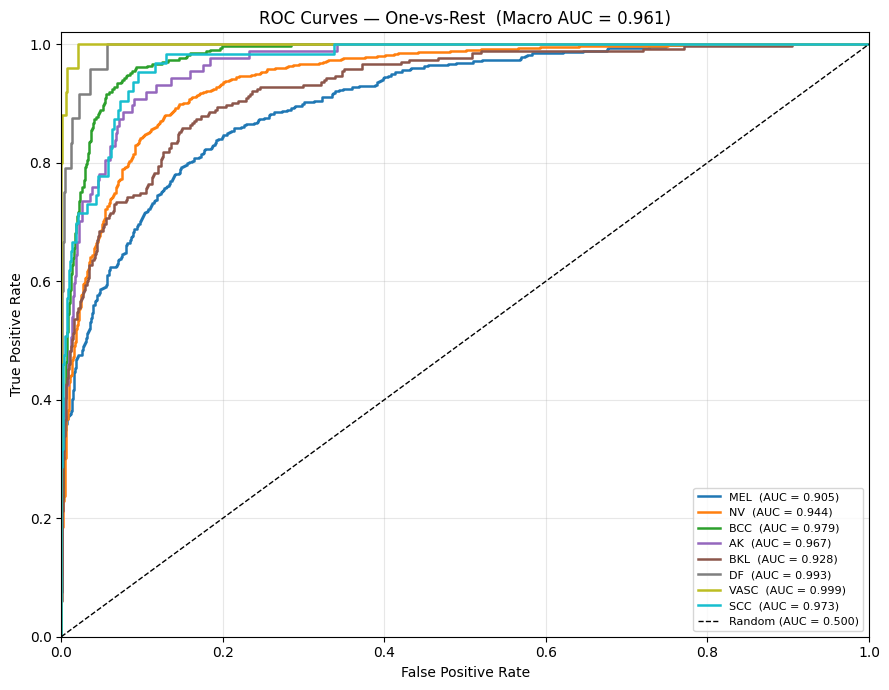


Per-class AUC:
   VASC: 0.9985  ███████████████████████████████████████
     DF: 0.9933  ███████████████████████████████████████
    BCC: 0.9792  ███████████████████████████████████████
    SCC: 0.9730  ██████████████████████████████████████
     AK: 0.9671  ██████████████████████████████████████
     NV: 0.9443  █████████████████████████████████████
    BKL: 0.9280  █████████████████████████████████████
    MEL: 0.9051  ████████████████████████████████████

  Macro AUC : 0.9611
Saved → C:\Users\Mohammad\Downloads\archieve\roc_curves.png


In [29]:


fig, ax = plt.subplots(figsize=(9, 7))

auc_scores = {}
colors_roc = plt.cm.tab10(np.linspace(0, 1, NUM_CLASSES))

for i, (cls, color) in enumerate(zip(CLASS_NAMES, colors_roc)):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], all_probs[:, i])
    roc_auc     = auc(fpr, tpr)
    auc_scores[cls] = roc_auc
    ax.plot(fpr, tpr, color=color, lw=1.8,
            label=f"{cls}  (AUC = {roc_auc:.3f})")

# Macro-average AUC
macro_auc = np.mean(list(auc_scores.values()))
ax.plot([0, 1], [0, 1], "k--", lw=1, label="Random (AUC = 0.500)")
ax.set_xlim([0, 1]); ax.set_ylim([0, 1.02])
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
ax.set_title(f"ROC Curves — One-vs-Rest  (Macro AUC = {macro_auc:.3f})")
ax.legend(loc="lower right", fontsize=8)
ax.grid(alpha=0.3)

plt.tight_layout()
out_roc = CKPT_PATH.parent / "roc_curves.png"
plt.savefig(out_roc, dpi=120)
plt.show()

print(f"\nPer-class AUC:")
for cls, score in sorted(auc_scores.items(), key=lambda x: -x[1]):
    bar = "█" * int(score * 40)
    print(f"  {cls:>5s}: {score:.4f}  {bar}")
print(f"\n  Macro AUC : {macro_auc:.4f}")
print(f"Saved → {out_roc}")

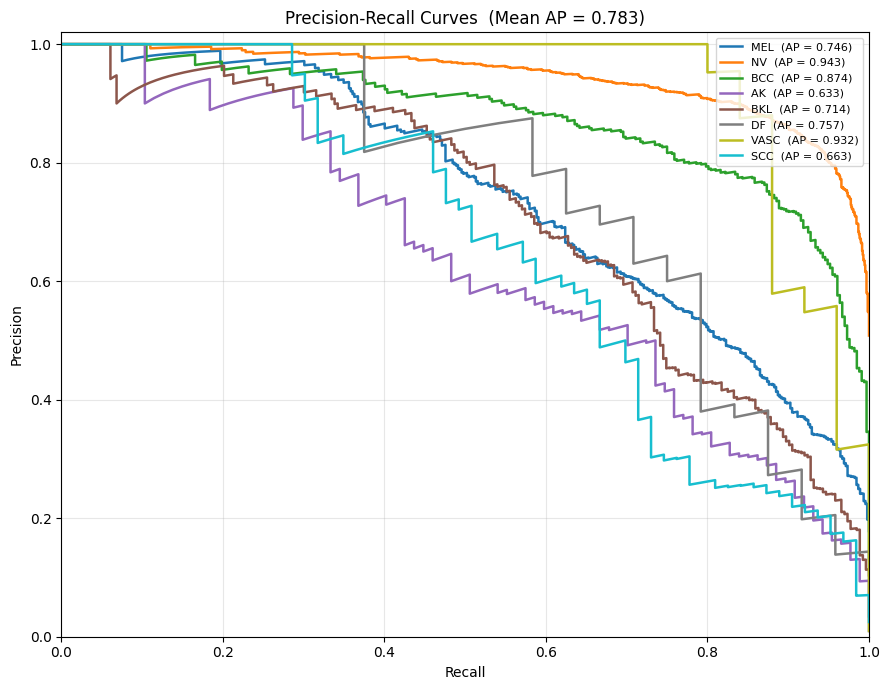


Per-class Average Precision:
     NV: 0.9434  █████████████████████████████████████
   VASC: 0.9323  █████████████████████████████████████
    BCC: 0.8742  ██████████████████████████████████
     DF: 0.7568  ██████████████████████████████
    MEL: 0.7460  █████████████████████████████
    BKL: 0.7138  ████████████████████████████
    SCC: 0.6632  ██████████████████████████
     AK: 0.6326  █████████████████████████

  Mean AP : 0.7828
Saved → C:\Users\Mohammad\Downloads\archieve\pr_curves.png


In [30]:


fig, ax = plt.subplots(figsize=(9, 7))

ap_scores = {}
colors_pr = plt.cm.tab10(np.linspace(0, 1, NUM_CLASSES))

for i, (cls, color) in enumerate(zip(CLASS_NAMES, colors_pr)):
    precision, recall, _ = precision_recall_curve(labels_bin[:, i], all_probs[:, i])
    ap = average_precision_score(labels_bin[:, i], all_probs[:, i])
    ap_scores[cls] = ap
    ax.plot(recall, precision, color=color, lw=1.8,
            label=f"{cls}  (AP = {ap:.3f})")

mean_ap = np.mean(list(ap_scores.values()))
ax.set_xlim([0, 1]); ax.set_ylim([0, 1.02])
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title(f"Precision-Recall Curves  (Mean AP = {mean_ap:.3f})")
ax.legend(loc="upper right", fontsize=8)
ax.grid(alpha=0.3)

plt.tight_layout()
out_pr = CKPT_PATH.parent / "pr_curves.png"
plt.savefig(out_pr, dpi=120)
plt.show()

print(f"\nPer-class Average Precision:")
for cls, score in sorted(ap_scores.items(), key=lambda x: -x[1]):
    bar = "█" * int(score * 40)
    print(f"  {cls:>5s}: {score:.4f}  {bar}")
print(f"\n  Mean AP : {mean_ap:.4f}")
print(f"Saved → {out_pr}")


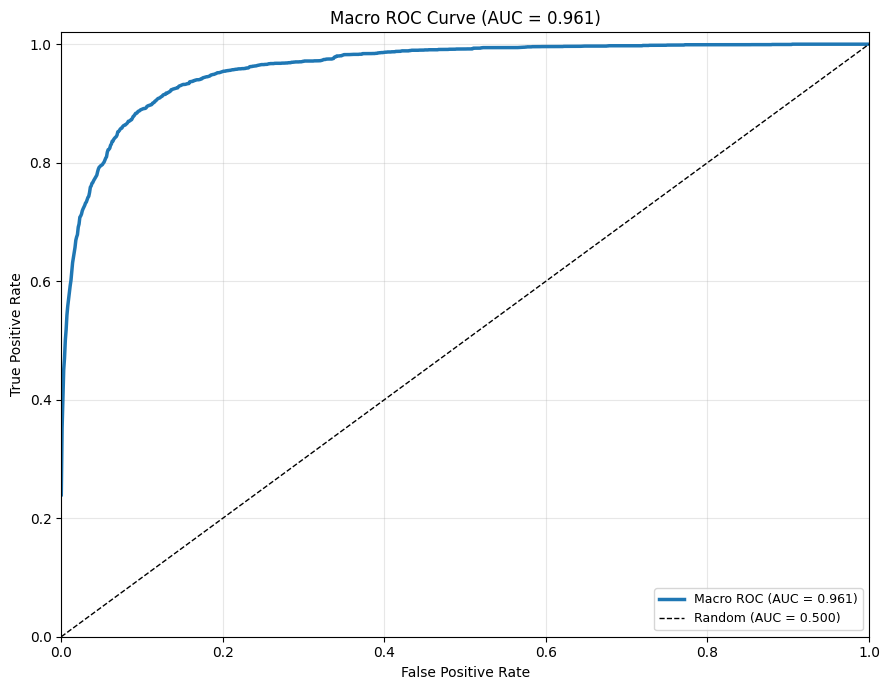

Macro ROC AUC: 0.9611
Saved → C:\Users\Mohammad\Downloads\archieve\roc_macro.png


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(9, 7))

# Common grid
fpr_grid = np.linspace(0.0, 1.0, 1001)
tpr_sum = np.zeros_like(fpr_grid)

# Average TPR across classes at the same FPR grid
for i in range(NUM_CLASSES):
    fpr_i, tpr_i, _ = roc_curve(labels_bin[:, i], all_probs[:, i])
    tpr_sum += np.interp(fpr_grid, fpr_i, tpr_i)

tpr_macro = tpr_sum / NUM_CLASSES
macro_auc = auc(fpr_grid, tpr_macro)

ax.plot(fpr_grid, tpr_macro, lw=2.5, label=f"Macro ROC (AUC = {macro_auc:.3f})")
ax.plot([0, 1], [0, 1], "k--", lw=1, label="Random (AUC = 0.500)")

ax.set_xlim([0, 1]); ax.set_ylim([0, 1.02])
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
ax.set_title(f"Macro ROC Curve (AUC = {macro_auc:.3f})")
ax.legend(loc="lower right", fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
out_roc = CKPT_PATH.parent / "roc_macro.png"
plt.savefig(out_roc, dpi=120)
plt.show()

print(f"Macro ROC AUC: {macro_auc:.4f}")
print(f"Saved → {out_roc}")


In [34]:
from sklearn.metrics import average_precision_score

pos_counts = labels_bin.sum(axis=0).astype(int)
print("Positives per class in THIS eval set:")
for cls, c in zip(CLASS_NAMES, pos_counts):
    print(f"  {cls:>5s}: {c}")

print("\nPer-class AP (will be undefined-ish if positives=0):")
for i, cls in enumerate(CLASS_NAMES):
    if pos_counts[i] == 0:
        print(f"  {cls:>5s}: skipped (no positives)")
        continue
    ap = average_precision_score(labels_bin[:, i], all_probs[:, i])
    print(f"  {cls:>5s}: {ap:.4f}")


Positives per class in THIS eval set:
    MEL: 452
     NV: 1288
    BCC: 332
     AK: 87
    BKL: 263
     DF: 24
   VASC: 25
    SCC: 63

Per-class AP (will be undefined-ish if positives=0):
    MEL: 0.7460
     NV: 0.9434
    BCC: 0.8742
     AK: 0.6326
    BKL: 0.7138
     DF: 0.7568
   VASC: 0.9323
    SCC: 0.6632


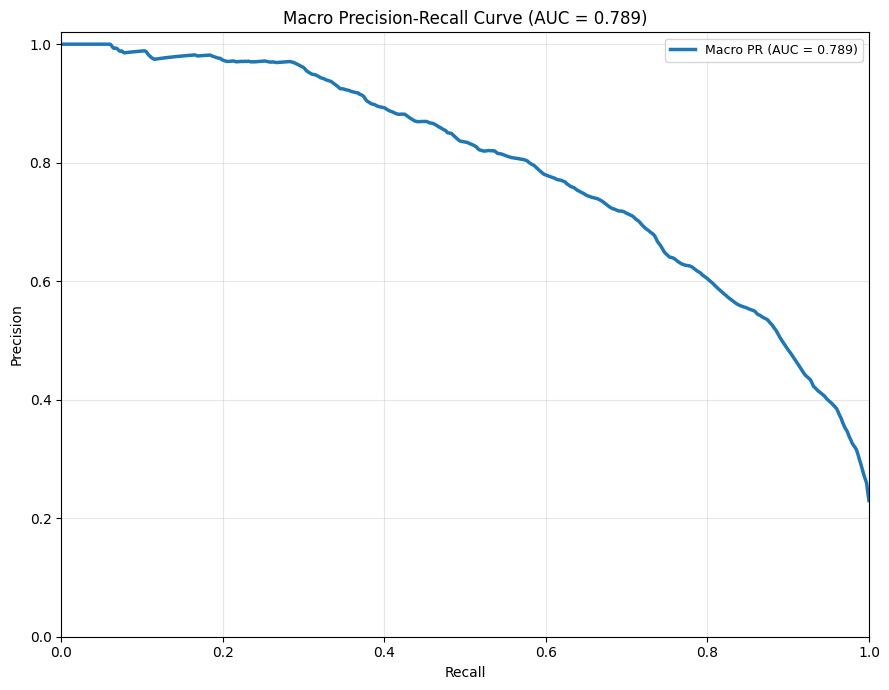

Macro PR AUC: 0.7887
Valid classes used: ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
Saved → C:\Users\Mohammad\Downloads\archieve\pr_macro.png


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

fig, ax = plt.subplots(figsize=(9, 7))

recall_grid = np.linspace(0.0, 1.0, 1001)

pos_counts = labels_bin.sum(axis=0).astype(int)
valid = [i for i in range(NUM_CLASSES) if pos_counts[i] > 0]

if len(valid) == 0:
    raise ValueError("No positive samples in any class for this eval set. PR curves are meaningless.")

prec_stack = []

for i in valid:
    prec_i, rec_i, _ = precision_recall_curve(labels_bin[:, i], all_probs[:, i])

    # Ensure recall is increasing for interpolation
    # (it usually is, but this keeps it safe)
    order = np.argsort(rec_i)
    rec_i = rec_i[order]
    prec_i = prec_i[order]

    # If recall has duplicates, keep the max precision at each recall
    rec_u, idx = np.unique(rec_i, return_index=True)
    prec_u = np.zeros_like(rec_u)
    for j, r in enumerate(rec_u):
        prec_u[j] = np.max(prec_i[rec_i == r])

    # Interpolate precision onto common recall grid
    prec_interp = np.interp(recall_grid, rec_u, prec_u, left=prec_u[0], right=prec_u[-1])
    prec_stack.append(prec_interp)

prec_macro = np.mean(np.vstack(prec_stack), axis=0)
macro_pr_auc = auc(recall_grid, prec_macro)

ax.plot(recall_grid, prec_macro, lw=2.5, label=f"Macro PR (AUC = {macro_pr_auc:.3f})")

ax.set_xlim([0, 1]); ax.set_ylim([0, 1.02])
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title(f"Macro Precision-Recall Curve (AUC = {macro_pr_auc:.3f})")
ax.legend(loc="upper right", fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
out_pr = CKPT_PATH.parent / "pr_macro.png"
plt.savefig(out_pr, dpi=120)
plt.show()

print("Macro PR AUC:", f"{macro_pr_auc:.4f}")
print("Valid classes used:", [CLASS_NAMES[i] for i in valid])
print("Saved →", out_pr)
